In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.font_manager as font_manager

# Make the font nicer
prop = matplotlib.font_manager.FontProperties(fname="C:\WINDOWS\Fonts\opensans-light.ttf")
matplotlib.rcParams['font.family'] = prop.get_name()

### Load fields for IDing tracts/regions

In [2]:
# Load field finder to label things later

field_finder = pd.read_csv("Field_finder_with_MHQ", sep='\t')

## Fractional anisotropy

### Load FA data and remove rows that represesent intercepts/offsets

In [3]:
# Load FA model trace
fa_summary = pd.read_csv("FA_trace_summary.csv")
fa_summary.columns = ['predictor' if 'Unnamed' in i else i for i in fa_summary.columns]

# remove boring things
fa_summary = fa_summary[~fa_summary.predictor.str.contains('offset')]
fa_summary = fa_summary[~fa_summary.predictor.str.contains('_0')]
fa_summary = fa_summary[~fa_summary.predictor.str.contains('1\|')]
fa_summary = fa_summary[~fa_summary.predictor.str.contains('_sd')]

### Identify "significant" tracts

Significance doesn't really exist in Bayesian stats, but arbitrary cutoffs are great so we use the Highest Posterior Density (HPD) intervals to indicate significance - these work like confidence intervals so if they don't cross zero we can treat them as meaningful effects

In [4]:
fa_sig = fa_summary[np.sign(fa_summary['hpd_2.5']) == np.sign(fa_summary['hpd_97.5'])].reset_index()

# Get the tract number (the number of the regressor in the model - this corresponds to the order in the input
# dataframe)
fa_sig['tract_number'] = fa_sig.predictor.str.extract('(\d+)')


C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """


Currently the tracts are just labelled with meaningless numbers - we want to convert this to the far more meaningful UKBB variable IDs that we started off with

In [5]:
tract_ids = pd.read_csv("tract_ids.txt").tract_id.tolist()

fa_sig['f.eid'] = None
for n, i in enumerate(fa_sig.tract_number.tolist()):
    fa_sig['f.eid'][n] = tract_ids[int(i)]

C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


And lastly, it would be helpful to give these actual names so we do this by matching these IDs with those in the field finder.

In [6]:
fa_sig_fields = pd.merge(fa_sig, field_finder, on='f.eid')
print fa_sig_fields


   index             predictor      mean        sd  mc_error   hpd_2.5  \
0    449   adult_risk|tract__5  0.023050  0.006190  0.000619  0.013247   
1    450   adult_risk|tract__6 -0.009623  0.004293  0.000429 -0.020900   
2    486  adult_risk|tract__42 -0.007203  0.004367  0.000437 -0.016055   
3    490  adult_risk|tract__46  0.013393  0.005108  0.000511  0.001187   

   hpd_97.5 tract_number        f.eid     1  \
0  0.037924            5  f.25061.2.0  8379   
1 -0.002737            6  f.25062.2.0  8380   
2 -0.000499           42  f.25098.2.0  8416   
3  0.022262           46  f.25102.2.0  8420   

                                                  ID  
0               Mean.FA.in.fornix.on.FA.skeleton.2.0  
1  Mean.FA.in.corticospinal.tract.on.FA.skeleton....  
2  Mean.FA.in.superior.fronto.occipital.fasciculu...  
3        Mean.FA.in.tapetum.on.FA.skeleton.right.2.0  


And then use some regex and replacements to make these more readable

In [7]:
fa_sig_fields['Tract'] = fa_sig_fields['ID'].str.extract('(?<=in\.)([a-zA-Z.].*?(?=\.on))')
fa_sig_fields['Tract'] = fa_sig_fields['Tract'].str.replace('.', ' ')
print fa_sig_fields


   index             predictor      mean        sd  mc_error   hpd_2.5  \
0    449   adult_risk|tract__5  0.023050  0.006190  0.000619  0.013247   
1    450   adult_risk|tract__6 -0.009623  0.004293  0.000429 -0.020900   
2    486  adult_risk|tract__42 -0.007203  0.004367  0.000437 -0.016055   
3    490  adult_risk|tract__46  0.013393  0.005108  0.000511  0.001187   

   hpd_97.5 tract_number        f.eid     1  \
0  0.037924            5  f.25061.2.0  8379   
1 -0.002737            6  f.25062.2.0  8380   
2 -0.000499           42  f.25098.2.0  8416   
3  0.022262           46  f.25102.2.0  8420   

                                                  ID  \
0               Mean.FA.in.fornix.on.FA.skeleton.2.0   
1  Mean.FA.in.corticospinal.tract.on.FA.skeleton....   
2  Mean.FA.in.superior.fronto.occipital.fasciculu...   
3        Mean.FA.in.tapetum.on.FA.skeleton.right.2.0   

                                  Tract  
0                                fornix  
1                   corticos

C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.


### Plots

This plot shows the means of the parameter estimates with the 2.5% and 97.5% HPD intervals.

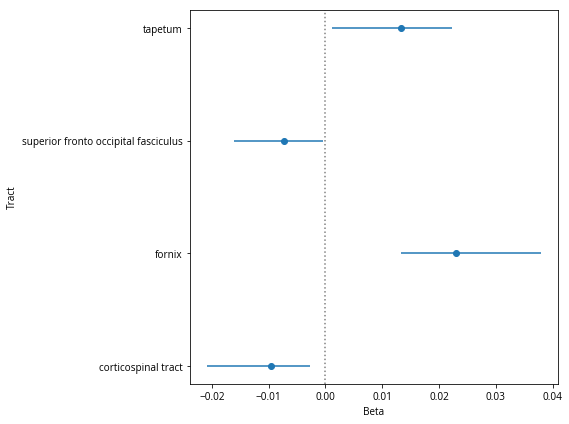

In [8]:
plt.clf()
plt.figure(figsize=(8, 6))
plt.scatter('mean', 'Tract', label=None, data=fa_sig_fields)
plt.errorbar('mean', 'Tract', xerr=[fa_sig_fields['mean'] - fa_sig_fields['hpd_2.5'], 
                                     fa_sig_fields['hpd_97.5'] -  fa_sig_fields['mean']],
             fmt='none', label=None, data=fa_sig_fields)
plt.xlabel("Beta")
plt.ylabel("Tract")
plt.axvline(0, linestyle=':', c='grey')
plt.tight_layout()
plt.show()

## Grey matter volume

### Load GMV data

In [9]:
gmv_summary = pd.read_csv("GMV_trace_summary.csv")
gmv_summary.columns = ['predictor' if 'Unnamed' in i else i for i in gmv_summary.columns]

# remove boring things
gmv_summary = gmv_summary[~gmv_summary.predictor.str.contains('offset')]
gmv_summary = gmv_summary[~gmv_summary.predictor.str.contains('_0')]
gmv_summary = gmv_summary[~gmv_summary.predictor.str.contains('1\|')]
gmv_summary = gmv_summary[~gmv_summary.predictor.str.contains('_sd')]

### Find significant results

In [10]:
gmv_sig = gmv_summary[np.sign(gmv_summary['hpd_2.5']) == np.sign(gmv_summary['hpd_97.5'])].reset_index()

gmv_sig['region_number'] = gmv_sig.predictor.str.extract('(\d+)')

region_ids = pd.read_csv("region_ids.txt").region_id.tolist()

gmv_sig['f.eid'] = None
for n, i in enumerate(gmv_sig.region_number.tolist()):
    gmv_sig['f.eid'][n] = region_ids[int(i)]


C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### Rename things

In [11]:
gmv_sig_fields = pd.merge(gmv_sig, field_finder, on='f.eid')

gmv_sig_fields['Region'] = gmv_sig_fields['ID'].str.replace('Volume.of.grey.matter.in.', '')
gmv_sig_fields['Region'] = gmv_sig_fields['Region'].str.extract('([a-zA-Z.]+)')
gmv_sig_fields['Region'] = gmv_sig_fields['Region'].str.replace('.', ' ')
gmv_sig_fields['Region'] = gmv_sig_fields['Region'].str.replace('Heschl s Gyrus includes H', "Heschl's Gyrus")

print gmv_sig_fields

    index               predictor      mean        sd  mc_error   hpd_2.5  \
0    1399    adult_risk|region__1 -0.006934  0.003495  0.000350 -0.013933   
1    1411   adult_risk|region__13  0.006753  0.003321  0.000332  0.001536   
2    1412   adult_risk|region__14 -0.051512  0.006091  0.000609 -0.062485   
3    1413   adult_risk|region__15 -0.028283  0.003754  0.000375 -0.034869   
4    1414   adult_risk|region__16 -0.033322  0.004341  0.000434 -0.042302   
5    1418   adult_risk|region__20 -0.007024  0.003593  0.000359 -0.013890   
6    1419   adult_risk|region__21 -0.013553  0.003507  0.000351 -0.020084   
7    1420   adult_risk|region__22 -0.016786  0.003573  0.000357 -0.023774   
8    1424   adult_risk|region__26  0.006650  0.003158  0.000316  0.000527   
9    1425   adult_risk|region__27 -0.010958  0.003448  0.000345 -0.018369   
10   1426   adult_risk|region__28 -0.010779  0.003131  0.000313 -0.018154   
11   1428   adult_risk|region__30 -0.006455  0.003469  0.000347 -0.013416   

C:\Users\Toby\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  after removing the cwd from sys.path.


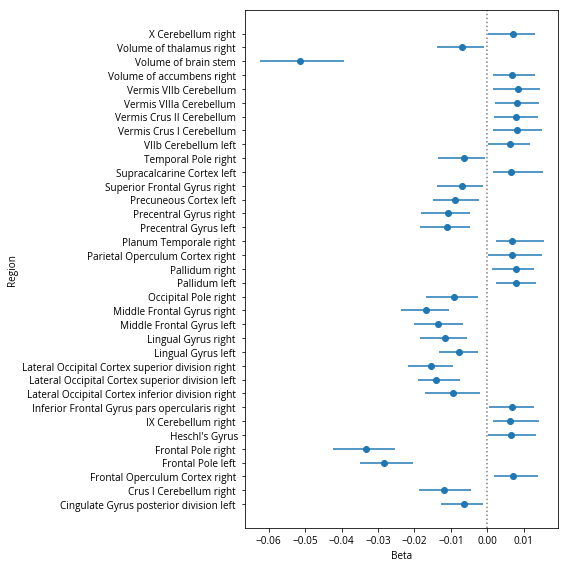

In [12]:
plt.clf()
plt.figure(figsize=(8, 8))
plt.scatter('mean', 'Region', label=None, data=gmv_sig_fields)
plt.errorbar('mean', 'Region', xerr=[gmv_sig_fields['mean'] - gmv_sig_fields['hpd_2.5'], 
                                     gmv_sig_fields['hpd_97.5'] -  gmv_sig_fields['mean']],
             fmt='none', label=None, data=gmv_sig_fields)
plt.xlabel("Beta")
plt.ylabel("Region")
plt.axvline(0, linestyle=':', c='grey')
plt.tight_layout()
plt.show()